In [38]:
!pip install xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [39]:
import pandas as pd
import numpy as np


# Load dataset
df = pd.read_csv("SCMS_Delivery_History_Dataset.csv", encoding='latin1')

original_df = df.copy()

# --- Basic Info ---
df = df.drop_duplicates()

# --- Feature Engineering: Time-based Columns ---
df['Delay_Flag'] = (
    pd.to_datetime(df['Delivered to Client Date'], errors='coerce') >
    pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce')
).astype(bool)

df['PO_Lead_Days'] = (
    pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce') -
    pd.to_datetime(df['PO Sent to Vendor Date'], errors='coerce')
).dt.days

df['Delivery_Delay_Days'] = (
    pd.to_datetime(df['Delivered to Client Date'], errors='coerce') -
    pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce')
).dt.days

df['Scheduled_Month'] = pd.to_datetime(
    df['Scheduled Delivery Date'], errors='coerce'
).dt.month

# --- Drop Irrelevant or High-Missing Columns ---
df = df.drop(columns=["ID"])

# Drop rows with missing Shipment Mode
df = df.dropna(subset=["Shipment Mode"]).reset_index(drop=True)

# --- Fill Missing Values ---
df['Dosage'] = df['Dosage'].fillna(df['Dosage'].mode()[0])
df['Line Item Insurance (USD)'] = df['Line Item Insurance (USD)'].fillna(df['Line Item Insurance (USD)'].mean())

# --- Date Column Cleanup ---
date_columns = [
    'PQ First Sent to Client Date',
    'PO Sent to Vendor Date',
    'Scheduled Delivery Date',
    'Delivered to Client Date',
    'Delivery Recorded Date'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# --- Expand Date Columns into Year / Month / Day ---
# to_expand = ['Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']
# for col in to_expand:
#     df[f"{col} year"] = df[col].dt.year
#     df[f"{col} month"] = df[col].dt.month
#     df[f"{col} day"] = df[col].dt.day
# df = df.drop(columns=to_expand)


to_expand = ['Scheduled Delivery Date']
for col in to_expand:
    df[f"{col} year"] = df[col].dt.year
    df[f"{col} month"] = df[col].dt.month
    df[f"{col} day"] = df[col].dt.day
df = df.drop(columns=to_expand)

# --- Drop Columns with Non-Numeric Entries ---
df = df.drop(columns=['Weight (Kilograms)', 'Freight Cost (USD)'])

# --- Drop ID Columns with No Predictive Value ---
df = df.drop(columns=['PQ #', 'PO / SO #', 'ASN/DN #'])

# --- Drop Other High-Missing or Categorical Columns ---
df = df.drop(columns=[
    "PQ First Sent to Client Date",
    "PO Sent to Vendor Date",
    "Item Description",
    "Molecule/Test Type",
    "Dosage",
    "Manufacturing Site"
])

print(df.columns)

# --- One-Hot Encoding for Remaining Object Columns ---
for col in df.select_dtypes(include='object').columns:
    dummies = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns=col)

# Final check
df.info()

/var/folders/h1/vkr4zpv117z38_52wn7s6yxm0000gn/T/ipykernel_95063/1837756712.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df['Delivered to Client Date'], errors='coerce') >
/var/folders/h1/vkr4zpv117z38_52wn7s6yxm0000gn/T/ipykernel_95063/1837756712.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce')
/var/folders/h1/vkr4zpv117z38_52wn7s6yxm0000gn/T/ipykernel_95063/1837756712.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df['Scheduled Delivery Date'], errors='coerce') -

Index(['Project Code', 'Country', 'Managed By', 'Fulfill Via',
       'Vendor INCO Term', 'Shipment Mode', 'Delivered to Client Date',
       'Delivery Recorded Date', 'Product Group', 'Sub Classification',
       'Vendor', 'Brand', 'Dosage Form', 'Unit of Measure (Per Pack)',
       'Line Item Quantity', 'Line Item Value', 'Pack Price', 'Unit Price',
       'First Line Designation', 'Line Item Insurance (USD)', 'Delay_Flag',
       'PO_Lead_Days', 'Delivery_Delay_Days', 'Scheduled_Month',
       'Scheduled Delivery Date year', 'Scheduled Delivery Date month',
       'Scheduled Delivery Date day'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9964 entries, 0 to 9963
Columns: 367 entries, Delivered to Client Date to First Line Designation_Yes
dtypes: bool(353), datetime64[ns](2), float64(5), int32(4), int64(3)
memory usage: 4.3 MB


/var/folders/h1/vkr4zpv117z38_52wn7s6yxm0000gn/T/ipykernel_95063/1837756712.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [40]:
df.shape

(9964, 367)

In [41]:
# X = df.drop(columns=["Delay_Flag"])
# # X = X.drop(columns=["Delivery_Delay_Days", "PO_Lead_Days"])
# X = X.drop(columns=["Delivery_Delay_Days"])
# X = X.select_dtypes(include=["number", "bool"])  # keep numeric and boolean columns
# # ✅ Target variable
# y = df["Delay_Flag"]
# y_delay_days = df["Delivery_Delay_Days"]

In [42]:
X = df.drop(columns=["Delay_Flag", "Delivery_Delay_Days"])
X = X.select_dtypes(include=["number", "bool"])
y_delay_days = df.loc[X.index, "Delivery_Delay_Days"]

In [43]:
from sklearn.model_selection import train_test_split


# 1. Split your data (you already have this)
X_train, X_test, y_days_train, y_days_test = train_test_split(
    X, y_delay_days, test_size=0.3, random_state=42
)

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import RobustScaler, QuantileTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor





pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()),
    # ('scaler', QuantileTransformer(output_distribution='normal')),  # or RobustScaler()
    # ('regressor', XGBRegressor())
    ('regressor', RandomForestRegressor())
])


# 3. Train the model
pipeline.fit(X_train, y_days_train)

# 4. Predict
y_pred_days = pipeline.predict(X_test)

# 5. Evaluate
mae = mean_absolute_error(y_days_test, y_pred_days)
mse = mean_squared_error(y_days_test, y_pred_days)
rmse = mse ** 0.5
r2 = r2_score(y_days_test, y_pred_days)

print("📊 Gradient Boosting Regression - Predict Delay Days")
print(f"MAE:  {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R²:   {r2:.4f}")

📊 Gradient Boosting Regression - Predict Delay Days
MAE:  7.38 days
RMSE: 16.90 days
R²:   0.6042


/var/folders/h1/vkr4zpv117z38_52wn7s6yxm0000gn/T/ipykernel_95063/368125018.py:12: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


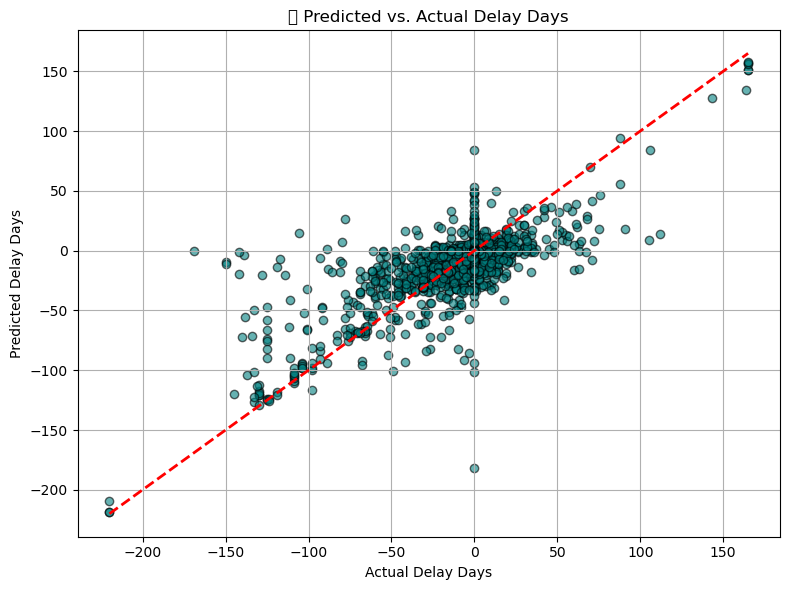

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_days_test, y_pred_days, alpha=0.6, color='teal', edgecolor='k')
plt.plot([y_days_test.min(), y_days_test.max()],
         [y_days_test.min(), y_days_test.max()],
         'r--', lw=2)  # Ideal line: predicted = actual
plt.xlabel('Actual Delay Days')
plt.ylabel('Predicted Delay Days')
plt.title('📉 Predicted vs. Actual Delay Days')
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd

# Ensure y_days_test and y_pred_days are Series with proper index
y_days_test = pd.Series(y_days_test, index=X_test.index, name="True_Delay_Days")
y_pred_days = pd.Series(y_pred_days, index=X_test.index, name="Predicted_Delay_Days")

# Combine everything
results_df = pd.concat([X_test.reset_index(drop=True),
                        y_days_test.reset_index(drop=True),
                        y_pred_days.reset_index(drop=True)], axis=1)

results_df['ID'] = original_df['ID']
# Save to CSV
results_df.to_csv("regression_results.csv", index=False)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor


models = {
    "Linear (Robust)": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),
        ("model", LinearRegression())
    ]),
    
    "Ridge (Quantile)": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", QuantileTransformer(output_distribution='normal')),
        ("model", Ridge())
    ]),

    "Lasso (Robust)": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),
        ("model", Lasso())
    ]),

    "SVR (Quantile)": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", QuantileTransformer(output_distribution='normal')),
        ("model", SVR())
    ]),

    "KNN Regressor (Robust)": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),
        ("model", KNeighborsRegressor())
    ]),

    "Random Forest": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),  # optional for trees
        ("model", RandomForestRegressor(random_state=42))
    ]),

    "Gradient Boosting": Pipeline([
        ("imputer", KNNImputer(n_neighbors=5)),
        ("scaler", RobustScaler()),
        ("model", GradientBoostingRegressor(random_state=42))
    ]),
}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_days_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_days_test, y_pred)
    # rmse = mean_squared_error(y_days_test, y_pred, squared=False)
    r2 = r2_score(y_days_test, y_pred)

    print(f"📊 {name}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}\n")

📊 Linear (Robust)
  MAE:  1604779627.40
  RMSE: 16.90
  R²:   -833973068356831744.0000

📊 Ridge (Quantile)
  MAE:  12.08
  RMSE: 16.90
  R²:   0.2718

📊 Lasso (Robust)
  MAE:  12.59
  RMSE: 16.90
  R²:   0.1481

📊 SVR (Quantile)
  MAE:  10.32
  RMSE: 16.90
  R²:   0.0987

📊 KNN Regressor (Robust)
  MAE:  11.42
  RMSE: 16.90
  R²:   0.2018

📊 Random Forest
  MAE:  7.74
  RMSE: 16.90
  R²:   0.5859

📊 Gradient Boosting
  MAE:  10.21
  RMSE: 16.90
  R²:   0.4182

